<a href="https://colab.research.google.com/github/DeL-TaiseiOzaki/DeL-TaiseiOzaki/blob/main/GCI_Second_compe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

##ライブラリ・データの読み込み

In [6]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
INPUT_DIR = "/content/drive/MyDrive/A_4_Data science/GCI2023/第2回コンペティション/input"

Mounted at /content/drive


In [8]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。

train = pd.read_csv(INPUT_DIR + "/train.csv")
test = pd.read_csv(INPUT_DIR + "/test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "/sample_submission.csv")

##参考プログラム

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

df_all = pd.concat([train, test], axis=0)

def one_hot_encoding(df):
    return_df = pd.get_dummies(df, drop_first=True)
    return return_df

def to_add_feature(df):
    df['EXT_123_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 3
    df['EXT_23_mean'] = (df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 2
    df['EXT_12_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2']) / 2
    df['EXT_13_mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_3']) / 2
    df['EXT_23_sabun'] = abs(df['EXT_SOURCE_2'] - df['EXT_SOURCE_3'])
    df['EXT_12_sabun'] = abs(df['EXT_SOURCE_1'] - df['EXT_SOURCE_2'])
    df['EXT_13_sabun'] = abs(df['EXT_SOURCE_1'] - df['EXT_SOURCE_3'])
    df['CREDIT_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['CREDIT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INCOME_TOTAL_ANNUITY'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TOTAL_CREDIT'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['DAYS_BIRTH_365_OWN_CAR_AGE'] = (df['DAYS_BIRTH'] / 365) - df['OWN_CAR_AGE']
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    return df

def to_drop(df):
    drop_list = ['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION']
    droped_df = df.drop(columns=drop_list)
    return droped_df

def fit_lgbm(X, y, cv, params: dict=None, verbose=100):

    oof_preds = np.zeros(X.shape[0])

    if params is None:
        params = {}

    models = []

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params, random_state=71, n_estimators=10000)
        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                early_stopping_rounds=100,
                eval_metric='auc',
                verbose=verbose)

        models.append(clf)
        oof_preds[idx_valid] = clf.predict_proba(x_valid, num_iteration=clf.best_iteration_)[:, 1]
        print('Fold %2d AUC : %.6f' % (i + 1, roc_auc_score(y_valid, oof_preds[idx_valid])))

    score = roc_auc_score(y, oof_preds)
    print('Full AUC score %.6f' % score)
    return oof_preds, models

df_encoded = one_hot_encoding(df_all)
added_features_df = to_add_feature(df_encoded)
all_features_df = to_drop(added_features_df)

train_ref = all_features_df[all_features_df.loc[:, 'SK_ID_CURR'] < 171202]
test_ref = all_features_df[all_features_df.loc[:, 'SK_ID_CURR'] > 171201]
train_x_ref = train_ref.drop(columns=['TARGET', 'SK_ID_CURR'])
train_y_ref = train['TARGET']
test_x_ref = test_ref.drop(columns=['TARGET','SK_ID_CURR'])
X_ref = train_x_ref.values
y_ref = train_y_ref.values

fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=69)
cv = list(fold.split(X_ref, y_ref))
lgbm_best_param = {'reg_lambda': 1.1564659040946654,
                   'reg_alpha': 9.90877329623665,
                   'colsample_bytree': 0.5034991685866442,
                   'subsample': 0.6055998601661783,
                   'max_depth': 3,
                   'min_child_weight': 39.72586351155486,
                   'learning_rate': 0.08532489659779158}
oof, models = fit_lgbm(X_ref, y_ref, cv=cv, params=lgbm_best_param)
pred = np.array([model.predict_proba(test_x_ref.values)[:, 1] for model in models])
pred_ref = np.mean(pred, axis=0)
print(pred_ref)

KeyboardInterrupt: ignored

##データの可視化と分析

In [13]:
lista = ["FLAG_CONT_MOBILE","REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION","LIVE_CITY_NOT_WORK_CITY",
                     "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]
train[lista].head(3)

,FLAG_CONT_MOBILE,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_CITY_NOT_WORK_CITY,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,1,2,0,1,0.0,0.0
1,1,2,0,0,0.0,0.0
2,1,2,0,0,4.0,0.0


In [14]:
test_feature = ["SK_ID_CURR","TARGET","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "AMT_INCOME_TOTAL", 'AMT_INCOME_TOTAL',
                'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',"CNT_CHILDREN"]
train5 = train[test_feature]

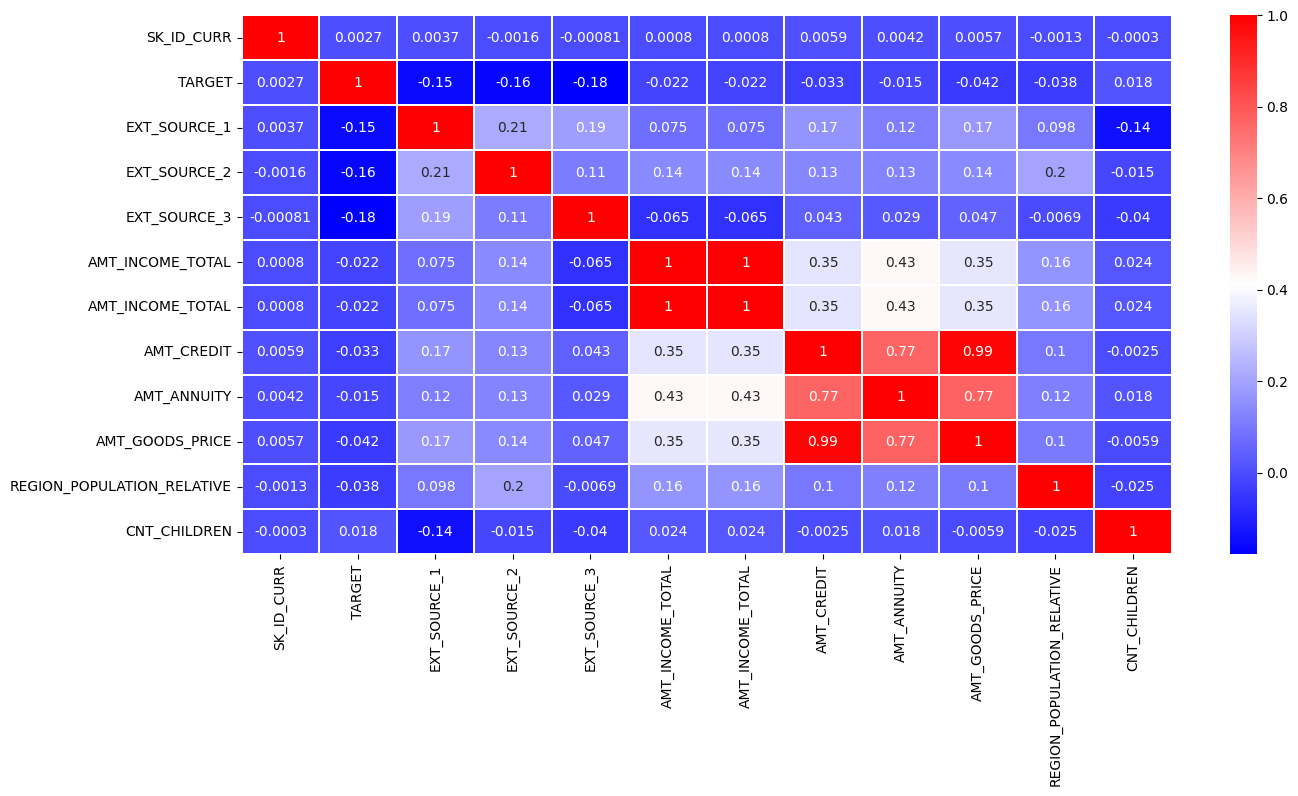

In [15]:
sns.heatmap(train5.corr(),annot=True,cmap='bwr',linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(15,7)
plt.show()

In [16]:
sns.displot(data=train, x="")
plt.show()

ValueError: ignored

##EXTシリーズの欠損値予測

###データフレーム整理

In [ ]:
# 欠損値を含まないカラムのみを抽出
filtered_df = train.dropna(axis=1)

cut_list = ["SK_ID_CURR","TARGET"]
filtered_df.drop(cut_list,axis=1,inplace = True)

#NAME_CONTRACT_TYPEの変換
filtered_df["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
#NAME_HOUSING_TYPE⇒「With parents」と「Rented」の確率が高いとみて，１とする．それ以外を０と変換
filtered_df["NAME_HOUSING_TYPE"].replace({'Co-op apartment': 0, 'House / apartment': 0,'Municipal apartment': 0
                                         ,'Office apartment': 0,'Rented apartment': 1,'With parents': 1}, inplace=True)
# ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = filtered_df["ORGANIZATION_TYPE"].value_counts()
filtered_df["ORGANIZATION_TYPE"]=filtered_df["ORGANIZATION_TYPE"].map(organization_ce)
#穴埋め
filtered_df["CODE_GENDER"] = filtered_df["CODE_GENDER"].replace('XNA', np.nan).fillna('F')
#CODE_GENDERのワンホットエンコーディング
code_gender = pd.get_dummies(filtered_df["CODE_GENDER"]).add_prefix("CODE_GENDER_")
filtered_df = pd.concat([filtered_df, code_gender], axis=1)
filtered_df.drop('CODE_GENDER', axis=1, inplace=True)
# NAME_INCOME_TYPEカテゴリの変換マップを作成
category_mapping = {'Working': 1, 'Pensioner': 1, 'State servant': 1, 'Commercial associate': 1,
                    'Student': 0, 'Businessman': 0, 'Maternity leave': 0, 'Unemployed': 0}
filtered_df['NAME_INCOME_TYPE'] = filtered_df['NAME_INCOME_TYPE'].map(category_mapping)
# NAME_EDUCATION_TYPEカテゴリの変換マップを作成
category_mapping = {'Higher education': 0, 'Secondary / secondary special': 1, 'Lower secondary': 1, 'Incomplete higher': 1,
                    'Academic degree': 0}
filtered_df['NAME_EDUCATION_TYPE'] = filtered_df['NAME_EDUCATION_TYPE'].map(category_mapping)
# NAME_FAMILY_STATUSカテゴリの変換マップを作成
category_mapping = {'Married':0, 'Widow':1, 'Single / not married':1,
                    'Separated':1,'Civil marriage':1, 'Unknown':1}
filtered_df['NAME_FAMILY_STATUS'] = filtered_df['NAME_FAMILY_STATUS'].map(category_mapping)

###EXT_SOURCE_2

In [ ]:
filtered_df["EXT_SOURCE_2"] = train["EXT_SOURCE_2"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data = filtered_df

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_2'].isnull()]
train_data = data[~data['EXT_SOURCE_2'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_2', axis=1)
y_train = train_data['EXT_SOURCE_2']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_2', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_2'].isnull(), 'EXT_SOURCE_2'] = predicted_values

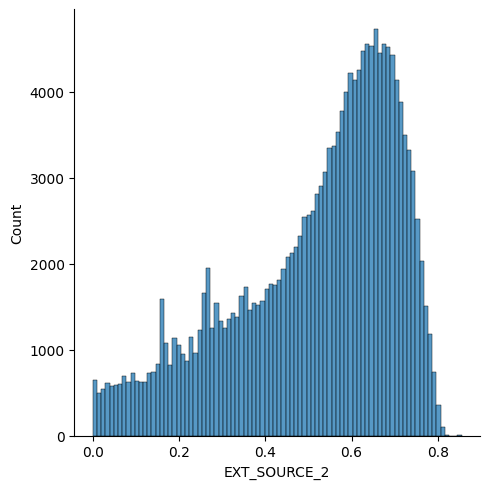

0.5144853327688751

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_2")
plt.show()
data["EXT_SOURCE_2"].mean()

###EXT_SOURCE_3



In [ ]:
data["EXT_SOURCE_3"] = train["EXT_SOURCE_3"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_3'].isnull()]
train_data = data[~data['EXT_SOURCE_3'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_3', axis=1)
y_train = train_data['EXT_SOURCE_3']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_3', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_3'].isnull(), 'EXT_SOURCE_3'] = predicted_values

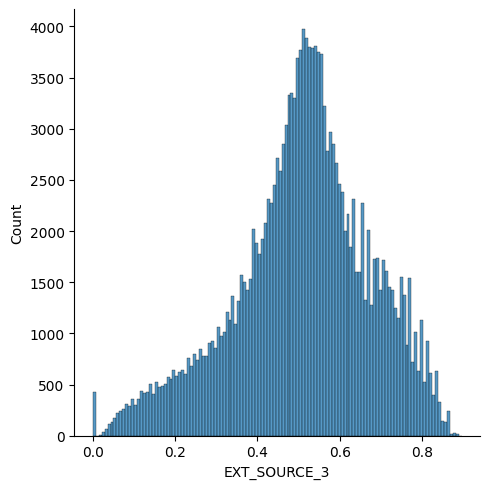

0.5082404139402711

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_3")
plt.show()
data["EXT_SOURCE_3"].mean()

###EXT_SOURCE_1



In [ ]:
data["EXT_SOURCE_1"] = train["EXT_SOURCE_1"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_1'].isnull()]
train_data = data[~data['EXT_SOURCE_1'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_1', axis=1)
y_train = train_data['EXT_SOURCE_1']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_1', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_1'].isnull(), 'EXT_SOURCE_1'] = predicted_values

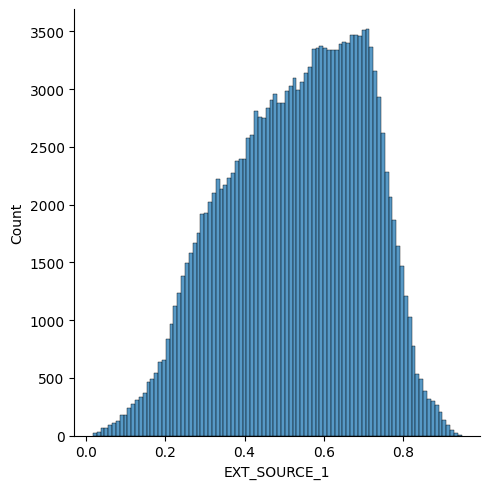

0.531411744795786

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_1")
plt.show()
data["EXT_SOURCE_1"].mean()

##EXTシリーズ欠損値予測２

###データフレーム整理

In [ ]:
test_feature = [ "AMT_INCOME_TOTAL",'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']
train_EXT = train[test_feature]

###欠損値埋め

In [ ]:
train_EXT["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].mean(), inplace=True)
train_EXT["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].mean(), inplace=True)

###EXT_SOURCE_2

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
train_EXT["EXT_SOURCE_2"] = train["EXT_SOURCE_2"]
data = train_EXT

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_2'].isnull()]
train_data = data[~data['EXT_SOURCE_2'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_2', axis=1)
y_train = train_data['EXT_SOURCE_2']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_2', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_2'].isnull(), 'EXT_SOURCE_2'] = predicted_values

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_2")
plt.show()
train["EXT_SOURCE_2"].mean()

###EXT_SOURCE_3

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_3"] = train["EXT_SOURCE_3"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_3'].isnull()]
train_data = data[~data['EXT_SOURCE_3'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_3', axis=1)
y_train = train_data['EXT_SOURCE_3']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_3', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_3'].isnull(), 'EXT_SOURCE_3'] = predicted_values

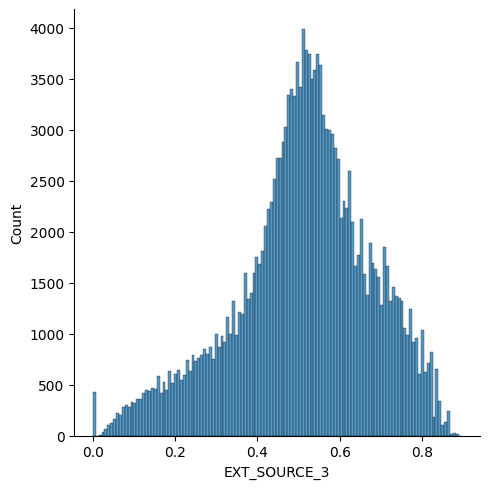

0.5111771488927159

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_3")
plt.show()
train["EXT_SOURCE_3"].mean()

###EXT_SOURCE_1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_1"] = train["EXT_SOURCE_1"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_1'].isnull()]
train_data = data[~data['EXT_SOURCE_1'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_1', axis=1)
y_train = train_data['EXT_SOURCE_1']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_1', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_1'].isnull(), 'EXT_SOURCE_1'] = predicted_values

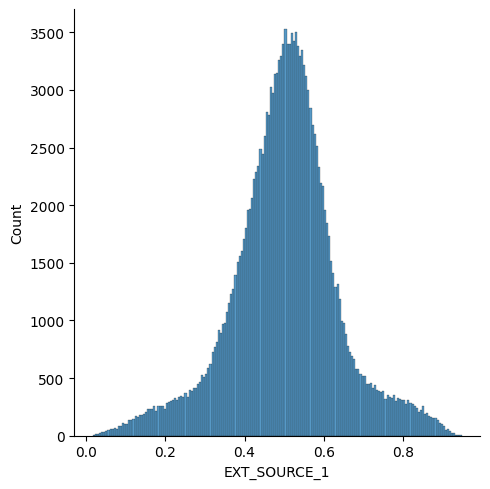

0.5016917304189625

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_1")
plt.show()
train["EXT_SOURCE_1"].mean()

###データフレーム整理

In [ ]:
test_feature = [ "AMT_INCOME_TOTAL",'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']
train_EXT = train[test_feature]

###欠損値埋め

In [ ]:
train_EXT["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].mean(), inplace=True)
train_EXT["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].mean(), inplace=True)

###EXT_SOURCE_2

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
train_EXT["EXT_SOURCE_2"] = train["EXT_SOURCE_2"]
data = train_EXT

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_2'].isnull()]
train_data = data[~data['EXT_SOURCE_2'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_2', axis=1)
y_train = train_data['EXT_SOURCE_2']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_2', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_2'].isnull(), 'EXT_SOURCE_2'] = predicted_values

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_2")
plt.show()
train["EXT_SOURCE_2"].mean()

###EXT_SOURCE_3

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_3"] = train["EXT_SOURCE_3"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_3'].isnull()]
train_data = data[~data['EXT_SOURCE_3'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_3', axis=1)
y_train = train_data['EXT_SOURCE_3']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_3', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_3'].isnull(), 'EXT_SOURCE_3'] = predicted_values

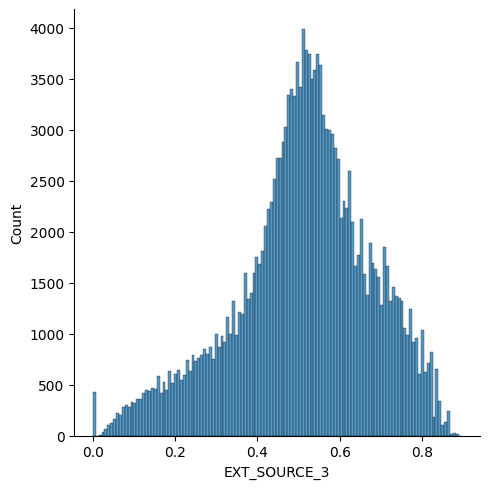

0.5111771488927159

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_3")
plt.show()
train["EXT_SOURCE_3"].mean()

###EXT_SOURCE_1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_1"] = train["EXT_SOURCE_1"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_1'].isnull()]
train_data = data[~data['EXT_SOURCE_1'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_1', axis=1)
y_train = train_data['EXT_SOURCE_1']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_1', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_1'].isnull(), 'EXT_SOURCE_1'] = predicted_values

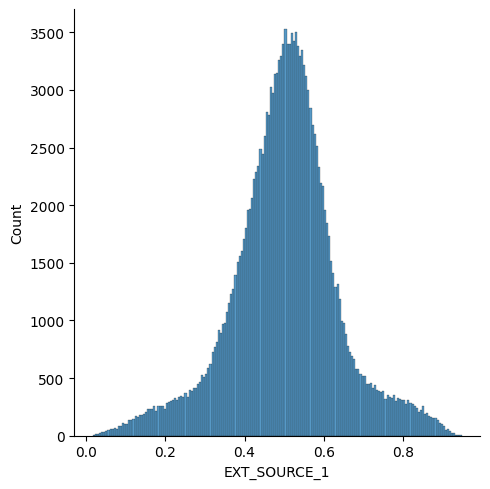

0.5016917304189625

In [ ]:
sns.displot(data=data, x="EXT_SOURCE_1")
plt.show()
train["EXT_SOURCE_1"].mean()

In [ ]:
#AMT_REQシリーズの処理
AMT_REQ_CREDIT_BUREAU = train.iloc[:, -4:]
AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU.sum(axis = 1) / 3
train_ver1 = train
train_ver1["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"]

#特徴量選択
use_features_ver1 = ["TARGET","NAME_CONTRACT_TYPE","CNT_CHILDREN","AMT_INCOME_TOTAL","AMT_CREDIT","NAME_HOUSING_TYPE","OCCUPATION_TYPE"
                    ,"REG_REGION_NOT_WORK_REGION","REG_CITY_NOT_WORK_CITY","ORGANIZATION_TYPE","EXT_SOURCE_2",
                    "AMT_REQ_CREDIT_BUREAU_SUM"]
use_features_ver2 = ["EXT_SOURCE_1","EXT_SOURCE_3","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_CONT_MOBILE","FLAG_PHONE","FLAG_EMAIL","OWN_CAR_AGE"]
use_features_ver2.extend(use_features_ver1)
use_features_ver3 = ["DAYS_BIRTH","DAYS_REGISTRATION","DAYS_ID_PUBLISH",
                     "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE"]
use_features_ver3.extend(use_features_ver2)
use_features_ver4 = ["CODE_GENDER","REGION_RATING_CLIENT","DAYS_EMPLOYED","CNT_FAM_MEMBERS","AMT_ANNUITY",
                     "AMT_GOODS_PRICE"]
use_features_ver4.extend(use_features_ver3)
train_ver5 = train_ver1[use_features_ver4]

#EXT_SOURCEの処理
train_ver5["EXT_SOURCE_SUM"] = 0.2*train_ver5["EXT_SOURCE_1"] + 0.5*train_ver5["EXT_SOURCE_2"] + 0.3*train_ver5["EXT_SOURCE_3"]
drop_feature = ["EXT_SOURCE_1","EXT_SOURCE_3"]
train_ver5 = train_ver5.drop(drop_feature,axis = 1)

#追加の特徴量
train_ver5['DAYS_EMPLOYED_PERC'] = train_ver5['DAYS_EMPLOYED'] / train_ver5['DAYS_BIRTH']
train_ver5['INCOME_CREDIT_PERC'] = train_ver5['AMT_INCOME_TOTAL'] / train_ver5['AMT_CREDIT']
train_ver5['INCOME_PER_PERSON'] = train_ver5['AMT_INCOME_TOTAL'] / train_ver5['CNT_FAM_MEMBERS']
train_ver5['ANNUITY_INCOME_PERC'] = train_ver5['AMT_ANNUITY'] / train_ver5['AMT_INCOME_TOTAL']
train_ver5['PAYMENT_RATE'] = train_ver5['AMT_ANNUITY'] / train_ver5['AMT_CREDIT']
train_ver5['credit_goods_price_rate'] = train_ver5['AMT_CREDIT'] / train_ver5['AMT_GOODS_PRICE']
train_ver5['credit_downpayment'] = train_ver5['AMT_GOODS_PRICE'] - train_ver5['AMT_CREDIT']
train_ver5['AGE_INT'] = int(train_ver5["DAYS_BIRTH"]/-365)


drop_feature = ["DAYS_EMPLOYED","CNT_FAM_MEMBERS","AMT_CREDIT","AMT_ANNUITY","DAYS_BIRTH","AMT_GOODS_PRICE",
                "AMT_INCOME_TOTAL"]
train_ver5 = train_ver5.drop(drop_feature,axis = 1)
#確定
train_transformed = train_ver5

##testデータのEXT加工


In [ ]:
test_feature = [ "AMT_INCOME_TOTAL",'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']
test_EXT = test[test_feature]
test_EXT["AMT_ANNUITY"].fillna(test["AMT_ANNUITY"].mean(), inplace=True)
test_EXT["AMT_GOODS_PRICE"].fillna(test["AMT_GOODS_PRICE"].mean(), inplace=True)

###testデータEXT処理

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
test_EXT["EXT_SOURCE_2"] = test["EXT_SOURCE_2"]
data = test_EXT

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_2'].isnull()]
train_data = data[~data['EXT_SOURCE_2'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_2', axis=1)
y_train = train_data['EXT_SOURCE_2']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_2', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_2'].isnull(), 'EXT_SOURCE_2'] = predicted_values

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_3"] = test["EXT_SOURCE_3"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_3'].isnull()]
train_data = data[~data['EXT_SOURCE_3'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_3', axis=1)
y_train = train_data['EXT_SOURCE_3']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_3', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_3'].isnull(), 'EXT_SOURCE_3'] = predicted_values

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# データセットの読み込み
data["EXT_SOURCE_1"] = test["EXT_SOURCE_1"]

# 欠損値を含むサンプルとそれ以外のサンプルに分割
test_data = data[data['EXT_SOURCE_1'].isnull()]
train_data = data[~data['EXT_SOURCE_1'].isnull()]

# 説明変数と目的変数の分割
X_train = train_data.drop('EXT_SOURCE_1', axis=1)
y_train = train_data['EXT_SOURCE_1']

# ランダムフォレストモデルの作成と学習
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 欠損値を予測
X_test = test_data.drop('EXT_SOURCE_1', axis=1)
predicted_values = model.predict(X_test)

# 欠損値を予測値で埋める
data.loc[data['EXT_SOURCE_1'].isnull(), 'EXT_SOURCE_1'] = predicted_values

## Dataset

In [9]:
#AMT_REQシリーズの処理
AMT_REQ_CREDIT_BUREAU = train.iloc[:, -4:]
AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU.sum(axis = 1) / 3
train_ver1 = train
train_ver1["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"]

#特徴量選択
use_features_ver1 = ["TARGET","NAME_CONTRACT_TYPE","CNT_CHILDREN","AMT_INCOME_TOTAL","AMT_CREDIT","NAME_HOUSING_TYPE",
                     "OCCUPATION_TYPE","REG_REGION_NOT_WORK_REGION","REG_CITY_NOT_WORK_CITY","ORGANIZATION_TYPE",
                     "EXT_SOURCE_2","AMT_REQ_CREDIT_BUREAU_SUM","AMT_REQ_CREDIT_BUREAU_HOUR"
                     ,"AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"]
use_features_ver2 = ["EXT_SOURCE_1","EXT_SOURCE_3","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_CONT_MOBILE","FLAG_PHONE",
                     "FLAG_EMAIL","OWN_CAR_AGE"]
use_features_ver2.extend(use_features_ver1)
use_features_ver3 = ["DAYS_BIRTH","DAYS_REGISTRATION","DAYS_ID_PUBLISH",
                     "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE"]
use_features_ver3.extend(use_features_ver2)
use_features_ver4 = ["CODE_GENDER","REGION_RATING_CLIENT","DAYS_EMPLOYED","CNT_FAM_MEMBERS","AMT_ANNUITY",
                     "AMT_GOODS_PRICE"]
use_features_ver4.extend(use_features_ver3)
use_features_ver5 = ["FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_FAMILY_STATUS","REGION_POPULATION_RELATIVE",
                     "REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION","DAYS_LAST_PHONE_CHANGE"]
use_features_ver5.extend(use_features_ver4)
use_features_ver6 = ["FLAG_CONT_MOBILE","REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION","LIVE_CITY_NOT_WORK_CITY",
                     "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]
use_features_ver6.extend(use_features_ver5)
train_ver6 = train_ver1[use_features_ver6]

#確定
train_transformed = train_ver6

#One-hot-encoding
def one_hot_encode(df, column):
    one_hot = pd.get_dummies(df[column]).add_prefix(column + '_')
    df = pd.concat([df, one_hot], axis=1)
    df.drop(column, axis=1, inplace=True)
    return df

#NAME_CONTRACT_TYPEの変換
train_transformed["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
#NAME_HOUSING_TYPE⇒「With parents」と「Rented」の確率が高いとみて，１とする．それ以外を０と変換
train_transformed["NAME_HOUSING_TYPE"].replace({'Co-op apartment': 0, 'House / apartment': 0,'Municipal apartment': 0
                                         ,'Office apartment': 0,'Rented apartment': 1,'With parents': 1}, inplace=True)
#OCCUPATION_TYPE⇒高確率の場合2，中確率のとき1,低確率のとき０
train_transformed["OCCUPATION_TYPE"].replace({'Cooking staff': 1, 'Drivers': 1,'Laborers': 1,'Cleaning staff':1,'Sales staff':1,
                                         'Low-skill Laborers': 1,'Security staff': 1,'Waiters/barmen staff': 1}, inplace=True)
train_transformed["OCCUPATION_TYPE"] = pd.to_numeric(train_transformed["OCCUPATION_TYPE"], errors='coerce').fillna(0)
#CNT_CHILDRENの01変換
train_transformed['CNT_CHILDREN'] = train_transformed['CNT_CHILDREN'].apply(lambda x: 0 if x == 0 else 1)
#NAME_FAMILY_STATUSの01変換
train_transformed['NAME_FAMILY_STATUS'] = train_transformed['NAME_FAMILY_STATUS'].apply(lambda x: 0 if x == 'Married' else 1)
#ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = train_ver1["ORGANIZATION_TYPE"].value_counts()
train_transformed["ORGANIZATION_TYPE"]=train_transformed["ORGANIZATION_TYPE"].map(organization_ce)
#穴埋め
train_transformed["CODE_GENDER"] = train_transformed["CODE_GENDER"].replace('XNA', np.nan).fillna('F')
#Onehotencoding
train_transformed = one_hot_encode(train_transformed,"CODE_GENDER")
train_transformed = one_hot_encode(train_transformed,"FLAG_OWN_CAR")
train_transformed = one_hot_encode(train_transformed,"FLAG_OWN_REALTY")
train_transformed = one_hot_encode(train_transformed,"NAME_TYPE_SUITE")
train_transformed = one_hot_encode(train_transformed,"REGION_RATING_CLIENT_W_CITY")
train_transformed = one_hot_encode(train_transformed,"REG_REGION_NOT_LIVE_REGION")
train_transformed['DAYS_BIRTH_365_OWN_CAR_AGE'] = (train_transformed['DAYS_BIRTH'] / -365) - train_transformed['OWN_CAR_AGE']
# OWN_CAR_AGEの60以上の値（外れ値）を欠損値扱いする
train_transformed.loc[train_transformed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
train_transformed["OWN_CAR_AGE"] = train_transformed["OWN_CAR_AGE"] // 10
train_transformed = one_hot_encode(train_transformed,"OWN_CAR_AGE")
#DAYS_EMPLOYEDの外れ値処理
train_transformed['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

#追加の特徴量
train_transformed['DAYS_EMPLOYED_PERC'] = train_transformed['DAYS_EMPLOYED'] / train_transformed['DAYS_BIRTH']
train_transformed['INCOME_CREDIT_PERC'] = train_transformed['AMT_INCOME_TOTAL'] / train_transformed['AMT_CREDIT']
train_transformed['INCOME_PER_PERSON'] = train_transformed['AMT_INCOME_TOTAL'] / train_transformed['CNT_FAM_MEMBERS']
train_transformed['ANNUITY_INCOME_PERC'] = train_transformed['AMT_ANNUITY'] / train_transformed['AMT_INCOME_TOTAL']
train_transformed['PAYMENT_RATE'] = train_transformed['AMT_ANNUITY'] / train_transformed['AMT_CREDIT']
train_transformed['credit_goods_price_rate'] = train_transformed['AMT_CREDIT'] / train_transformed['AMT_GOODS_PRICE']
train_transformed['credit_downpayment'] = train_transformed['AMT_GOODS_PRICE'] - train_transformed['AMT_CREDIT']
train_transformed['DAYS_EMPLOYED'] = train_transformed["DAYS_EMPLOYED"]/-365
train_transformed['DAYS_BIRTH'] = train_transformed["DAYS_BIRTH"]/-365
train_transformed['DAYS_ID_PUBLISH'] = train_transformed["DAYS_ID_PUBLISH"]/-365
train_transformed['DAYS_REGISTRATION'] = train_transformed["DAYS_REGISTRATION"]/-365
train_transformed['DAYS_LAST_PHONE_CHANGE'] = train_transformed["DAYS_LAST_PHONE_CHANGE"]/-365
train_transformed["INT_SUM"] = (train_transformed['DAYS_EMPLOYED']+train_transformed['DAYS_BIRTH']
                      +train_transformed['DAYS_ID_PUBLISH']+train_transformed['DAYS_REGISTRATION']+train_transformed['DAYS_LAST_PHONE_CHANGE']) / 5
train_transformed['OBS_30_60'] = (train_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] + train_transformed['OBS_60_CNT_SOCIAL_CIRCLE']) / 2
train_transformed['OBS_DEF_30'] = (train_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] + train_transformed['DEF_30_CNT_SOCIAL_CIRCLE']) / 2
train_transformed['DEF_30_60'] = (train_transformed['DEF_30_CNT_SOCIAL_CIRCLE'] + train_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 2
train_transformed['OBS_DEF_60'] = (train_transformed['OBS_60_CNT_SOCIAL_CIRCLE'] + train_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 2
train_transformed['OBS_DEF'] = (train_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] + train_transformed['OBS_60_CNT_SOCIAL_CIRCLE']+
                                train_transformed['DEF_30_CNT_SOCIAL_CIRCLE'] + train_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 4
train_transformed['EXT_23_mean'] = (train_transformed['EXT_SOURCE_2'] + train_transformed['EXT_SOURCE_3']) / 2
train_transformed['EXT_12_mean'] = (train_transformed['EXT_SOURCE_1'] + train_transformed['EXT_SOURCE_2']) / 2
train_transformed['EXT_13_mean'] = (train_transformed['EXT_SOURCE_1'] + train_transformed['EXT_SOURCE_3']) / 2
train_transformed['EXT_23_delta'] = abs(train_transformed['EXT_SOURCE_2'] - train_transformed['EXT_SOURCE_3'])
train_transformed['EXT_12_delta'] = abs(train_transformed['EXT_SOURCE_1'] - train_transformed['EXT_SOURCE_2'])
train_transformed['EXT_13_delta'] = abs(train_transformed['EXT_SOURCE_1'] - train_transformed['EXT_SOURCE_3'])
train_transformed['EXT_mean'] = (train_transformed['EXT_SOURCE_1'] + train_transformed['EXT_SOURCE_2']+train_transformed['EXT_SOURCE_3']) / 3
train_transformed['EXT_SOURCE_null'] = np.where(train_transformed['EXT_SOURCE_1'].isnull() & train_transformed['EXT_SOURCE_2'].isnull() & train_transformed['EXT_SOURCE_3'].isnull(), 1, 0)

In [10]:
#特徴量選択
use_features_ver1 = ["NAME_CONTRACT_TYPE","CNT_CHILDREN","AMT_INCOME_TOTAL","AMT_CREDIT","NAME_HOUSING_TYPE",
                     "OCCUPATION_TYPE","REG_REGION_NOT_WORK_REGION","REG_CITY_NOT_WORK_CITY","ORGANIZATION_TYPE",
                     "EXT_SOURCE_2","AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT"
                     ,"AMT_REQ_CREDIT_BUREAU_YEAR"]
use_features_ver2 = ["EXT_SOURCE_1","EXT_SOURCE_3","FLAG_EMP_PHONE","FLAG_WORK_PHONE","FLAG_CONT_MOBILE","FLAG_PHONE","FLAG_EMAIL","OWN_CAR_AGE"]
use_features_ver3 = ["DAYS_BIRTH","DAYS_REGISTRATION","DAYS_ID_PUBLISH",
                     "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE"]
use_features_ver4 = ["CODE_GENDER","REGION_RATING_CLIENT","DAYS_EMPLOYED","CNT_FAM_MEMBERS","AMT_ANNUITY","AMT_GOODS_PRICE"]
use_features_ver5 = ["FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_FAMILY_STATUS","REGION_POPULATION_RELATIVE",
                     "REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION","DAYS_LAST_PHONE_CHANGE"]
use_features_ver6 =  ["FLAG_CONT_MOBILE","REGION_RATING_CLIENT_W_CITY","REG_REGION_NOT_LIVE_REGION","LIVE_CITY_NOT_WORK_CITY",
                     "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"]
use_features_ver2.extend(use_features_ver1)
use_features_ver3.extend(use_features_ver2)
use_features_ver4.extend(use_features_ver3)
use_features_ver5.extend(use_features_ver4)
use_features_ver6.extend(use_features_ver5)
test_transformed = test[use_features_ver6]

#AMT_REQ_CREDIT_BUREAUの処理
AMT_REQ_CREDIT_BUREAU = test.iloc[:, -4:]
AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU.sum(axis = 1)
test_transformed["AMT_REQ_CREDIT_BUREAU_SUM"] = AMT_REQ_CREDIT_BUREAU["AMT_REQ_CREDIT_BUREAU_SUM"]
#NAME_CONTRACT_TYPEの変換
test_transformed["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
#NAME_HOUSING_TYPE⇒「With parents」と「Rented」の確率が高いとみて，１とする．それ以外を０と変換
test_transformed["NAME_HOUSING_TYPE"].replace({'Co-op apartment': 0, 'House / apartment': 0,'Municipal apartment': 0
                                         ,'Office apartment': 0,'Rented apartment': 1,'With parents': 1}, inplace=True)
#OCCUPATION_TYPE⇒高確率の場合2，中確率のとき1,低確率のとき０
test_transformed["OCCUPATION_TYPE"].replace({'Cooking staff': 1, 'Drivers': 1,'Laborers': 1,'Cleaning staff':1,'Sales staff':1,
                                         'Low-skill Laborers': 1,'Security staff': 1,'Waiters/barmen staff': 1}, inplace=True)
test_transformed["OCCUPATION_TYPE"] = pd.to_numeric(test_transformed["OCCUPATION_TYPE"], errors='coerce').fillna(0)
#ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = test_transformed["ORGANIZATION_TYPE"].value_counts()
test_transformed["ORGANIZATION_TYPE"]=test_transformed["ORGANIZATION_TYPE"].map(organization_ce)
#穴埋め
test_transformed["CODE_GENDER"] = test_transformed["CODE_GENDER"].replace('XNA', np.nan).fillna('F')
#CNT_CHILDRENの変換
test_transformed['CNT_CHILDREN'] = test_transformed['CNT_CHILDREN'].apply(lambda x: 0 if x == 0 else 1)
#NAME_FAMILY_STATUSの01変換
test_transformed['NAME_FAMILY_STATUS'] = test_transformed['NAME_FAMILY_STATUS'].apply(lambda x: 0 if x == 'Married' else 1)
#onehotencoding
test_transformed = one_hot_encode(test_transformed, "CODE_GENDER")
test_transformed = one_hot_encode(test_transformed, "FLAG_OWN_CAR")
test_transformed = one_hot_encode(test_transformed, "FLAG_OWN_REALTY")
test_transformed = one_hot_encode(test_transformed, "NAME_TYPE_SUITE")
test_transformed = one_hot_encode(test_transformed, "REGION_RATING_CLIENT_W_CITY")
test_transformed = one_hot_encode(test_transformed, "REG_REGION_NOT_LIVE_REGION")
test_transformed['DAYS_BIRTH_365_OWN_CAR_AGE'] = (test_transformed['DAYS_BIRTH'] / 365) - test_transformed['OWN_CAR_AGE']
#OWN_CAR_AGEの変換
test_transformed.loc[test_transformed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test_transformed["OWN_CAR_AGE"] = test_transformed["OWN_CAR_AGE"] // 10
test_car_age_ohe = pd.get_dummies(test_transformed["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_transformed = pd.concat([test_transformed, test_car_age_ohe], axis=1)
test_transformed.drop('OWN_CAR_AGE', axis=1, inplace=True)
#DAYS_EMPLOYEDの外れ値処理
test_transformed['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

#追加の特徴量
test_transformed['DAYS_EMPLOYED_PERC'] = test_transformed['DAYS_EMPLOYED'] / test_transformed['DAYS_BIRTH']
test_transformed['INCOME_CREDIT_PERC'] = test_transformed['AMT_INCOME_TOTAL'] / test_transformed['AMT_CREDIT']
test_transformed['INCOME_PER_PERSON'] = test_transformed['AMT_INCOME_TOTAL'] / test_transformed['CNT_FAM_MEMBERS']
test_transformed['ANNUITY_INCOME_PERC'] = test_transformed['AMT_ANNUITY'] / test_transformed['AMT_INCOME_TOTAL']
test_transformed['PAYMENT_RATE'] = test_transformed['AMT_ANNUITY'] / test_transformed['AMT_CREDIT']
test_transformed['credit_goods_price_rate'] = test_transformed['AMT_CREDIT'] / test_transformed['AMT_GOODS_PRICE']
test_transformed['credit_downpayment'] = test_transformed['AMT_GOODS_PRICE'] - test_transformed['AMT_CREDIT']
test_transformed['DAYS_EMPLOYED'] = test_transformed["DAYS_EMPLOYED"]/-365
test_transformed['DAYS_BIRTH'] = test_transformed["DAYS_BIRTH"]/-365
test_transformed['DAYS_ID_PUBLISH'] = test_transformed["DAYS_ID_PUBLISH"]/-365
test_transformed['DAYS_REGISTRATION'] = test_transformed["DAYS_REGISTRATION"]/-365
test_transformed['DAYS_LAST_PHONE_CHANGE'] = test_transformed["DAYS_LAST_PHONE_CHANGE"]/-365
test_transformed["INT_mean"] = (test_transformed['DAYS_EMPLOYED'] + test_transformed['DAYS_BIRTH']
                      +test_transformed['DAYS_ID_PUBLISH'] + test_transformed['DAYS_REGISTRATION'] + test_transformed['DAYS_LAST_PHONE_CHANGE']) / 5
test_transformed['OBS_30_60'] = (test_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] +test_transformed['OBS_60_CNT_SOCIAL_CIRCLE']) / 2
test_transformed['OBS_DEF_30'] = (test_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] +test_transformed['DEF_30_CNT_SOCIAL_CIRCLE']) / 2
test_transformed['DEF_30_60'] = (test_transformed['DEF_30_CNT_SOCIAL_CIRCLE'] +test_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 2
test_transformed['OBS_DEF_60'] = (test_transformed['OBS_60_CNT_SOCIAL_CIRCLE'] +test_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 2
test_transformed['OBS_DEF'] = (test_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] +test_transformed['OBS_60_CNT_SOCIAL_CIRCLE'] +
                               test_transformed['DEF_30_CNT_SOCIAL_CIRCLE'] +test_transformed['DEF_60_CNT_SOCIAL_CIRCLE']) / 4
test_transformed['EXT_23_mean'] = (test_transformed['EXT_SOURCE_2'] + test_transformed['EXT_SOURCE_3']) / 2
test_transformed['EXT_12_mean'] = (test_transformed['EXT_SOURCE_1'] + test_transformed['EXT_SOURCE_2']) / 2
test_transformed['EXT_13_mean'] = (test_transformed['EXT_SOURCE_1'] + test_transformed['EXT_SOURCE_3']) / 2
test_transformed['EXT_23_delta'] = abs(test_transformed['EXT_SOURCE_2'] - test_transformed['EXT_SOURCE_3'])
test_transformed['EXT_12_delta'] = abs(test_transformed['EXT_SOURCE_1'] - test_transformed['EXT_SOURCE_2'])
test_transformed['EXT_13_delta'] = abs(test_transformed['EXT_SOURCE_1'] - test_transformed['EXT_SOURCE_3'])
test_transformed['EXT_mean'] = (test_transformed['EXT_SOURCE_1'] + test_transformed['EXT_SOURCE_3']+test_transformed['EXT_SOURCE_3']) / 3
test_transformed['EXT_SOURCE_null'] = np.where(test_transformed['EXT_SOURCE_1'].isnull() & test_transformed['EXT_SOURCE_2'].isnull() & test_transformed['EXT_SOURCE_3'].isnull(), 1, 0)

##標準化と対数変換

In [ ]:
#正値化
train_abs = train_transformed.abs()
test_abs = test_transformed.abs()
#変換したいカラムのリスト
columns_to_transform = ["REGION_RATING_CLIENT","DAYS_BIRTH","DAYS_REGISTRATION","DAYS_ID_PUBLISH","OBS_30_CNT_SOCIAL_CIRCLE",
                        "DEF_30_CNT_SOCIAL_CIRCLE","ORGANIZATION_TYPE","AMT_REQ_CREDIT_BUREAU_SUM","EXT_SOURCE_SUM","AMT_CREDIT",
                        "ORGANIZATION_TYPE","CNT_CHILDREN"]
#元のデータフレームをコピー
train_transformed_std_log = train_abs.copy()
test_transformed_std_log = test_abs.copy()
for column in columns_to_transform:
    # 対数変換
    train_transformed[column] = np.log(train_abs[column]+1)
    test_transformed_std_log[column] = np.log(test_abs[column]+1)
    # 標準化
    train_transformed_std_log[column] = (train_transformed_std_log[column] - train_transformed_std_log[column].mean()) / train_transformed_std_log[column].std()
    test_transformed_std_log[column] = (test_transformed_std_log[column] - test_transformed_std_log[column].mean()) / test_transformed_std_log[column].std()

KeyError: ignored

##LightGBM用のデータ

In [17]:
train_lgb = train_transformed
test_lgb = test_transformed

In [18]:
train_lgb

,FLAG_CONT_MOBILE,LIVE_CITY_NOT_WORK_CITY,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,REGION_RATING_CLIENT,DAYS_EMPLOYED,CNT_FAM_MEMBERS,...,OBS_DEF_60,OBS_DEF,EXT_23_mean,EXT_12_mean,EXT_13_mean,EXT_23_delta,EXT_12_delta,EXT_13_delta,EXT_mean,EXT_SOURCE_null
0,1,1,0.0,0.0,0,0.010032,0.800000,2,2.405479,2.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,0,0.0,0.0,0,0.008019,1.690411,2,NaN,2.0,...,0.0,0.0,0.501366,NaN,NaN,0.103598,NaN,NaN,NaN,0
2,1,0,4.0,0.0,0,0.004960,1.484932,2,1.432877,2.0,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,0,0.0,0.0,1,0.005002,-0.000000,3,NaN,1.0,...,0.0,0.0,0.436379,NaN,NaN,0.662289,NaN,NaN,NaN,0
4,1,1,0.0,0.0,0,0.006296,3.405479,3,1.909589,2.0,...,0.0,0.0,0.435773,0.272417,0.5057,0.466567,0.139854,0.326713,0.40463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171197,1,1,0.0,0.0,0,0.031329,6.413699,2,8.380822,2.0,...,0.0,0.0,0.586684,NaN,NaN,0.364248,NaN,NaN,NaN,0
171198,1,0,0.0,0.0,1,0.010006,4.624658,2,0.353425,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
171199,1,0,2.0,1.0,0,0.006629,1.410959,2,6.947945,4.0,...,1.5,1.5,0.711349,NaN,NaN,0.094088,NaN,NaN,NaN,0
171200,1,0,0.0,0.0,1,0.009657,3.104110,2,0.452055,1.0,...,0.0,0.0,NaN,0.418984,NaN,NaN,0.416132,NaN,NaN,0


##機械学習モデルの作成

In [20]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [21]:
# 目的変数と説明変数に分割
X = train_transformed.drop("TARGET", axis=1).values
y = train_transformed["TARGET"].values
X_test = test_transformed.values

##Optunaによるパラメータチューニング

In [ ]:
!pip install optuna

In [ ]:
import optuna
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 目的関数の定義
def objective_lgb(trial):
    # パラメータの範囲を指定
    params = {
        'objective': 'binary',
        "boosting_type" : "gbdt",
        'metric': 'auc',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 2.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0.0, 50.0),
        'random_state': 71,
    }

    # データの分割
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # LightGBMモデルの学習
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # バリデーションデータでの予測
    y_pred = model.predict_proba(X_val)[:, 1]

    # AUCを評価指標として返す
    score = roc_auc_score(y_val, y_pred)
    return score

def objective_xgb(trial):
    # パラメータの範囲を指定
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'random_state': 71,
    }

    # データの分割
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # XGBoostモデルの学習
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # バリデーションデータでの予測
    y_pred = model.predict_proba(X_val)[:, 1]

    # AUCを評価指標として返す
    score = roc_auc_score(y_val, y_pred)
    return score

# Optunaによるパラメータチューニング（LightGBM）
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=80)
# 最適なパラメータの取得
best_params_lgb = study_lgb.best_params
print("LightGBM Best Parameters:", best_params_lgb)

# Optunaによるパラメータチューニング（XGBoost）
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=70)
# 最適なパラメータの取得
best_params_xgb = study_xgb.best_params
print("XGBoost Best Parameters:", best_params_xgb)

[I 2023-06-29 17:27:14,812] A new study created in memory with name: no-name-6166c75a-9238-4332-b161-9a6a1989c278
[I 2023-06-29 17:27:22,332] Trial 0 finished with value: 0.757964293539557 and parameters: {'num_leaves': 50, 'learning_rate': 0.1347780062510512, 'reg_lambda': 0.423815076974553, 'reg_alpha': 7.850043423057597, 'colsample_bytree': 0.4131979377809608, 'subsample': 0.3123408932958188, 'max_depth': 9, 'min_child_weight': 22.104430922561054}. Best is trial 0 with value: 0.757964293539557.
[I 2023-06-29 17:27:25,695] Trial 1 finished with value: 0.7349167971719974 and parameters: {'num_leaves': 32, 'learning_rate': 0.015385180678736893, 'reg_lambda': 1.8005053005913036, 'reg_alpha': 8.567532348042272, 'colsample_bytree': 0.7684347114017996, 'subsample': 0.8036477842690846, 'max_depth': 4, 'min_child_weight': 20.9394754349095}. Best is trial 0 with value: 0.757964293539557.
[I 2023-06-29 17:27:36,200] Trial 2 finished with value: 0.7555358089462539 and parameters: {'num_leaves':

##xgb&lgbの回帰

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# 目的変数と説明変数に分割
X = train_lgb.drop("TARGET", axis=1).values
y = train_lgb["TARGET"].values
X_test = test_lgb.values

#lgb&xgbのパラメータ
params_lgb = {'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': 'auc',
              'random_state': 71,
              }

params_xgb = {"booster":"gbtree",
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'random_state': 71,
              }

#パラメータの確定
params_lgb = {**params_lgb,**best_params_lgb}
params_xgb = {**params_xgb,**best_params_xgb}

# クロスバリデーションの設定
n_splits = 8  # 分割数
random_state = 71  # 乱数のシード値
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# クロスバリデーションループ
test_score_lgb = []
test_score_xgb = []
test_pred_lgb = []
test_pred_xgb = []

for train_index, val_index in skf.split(X,y):

    # 訓練データとバリデーションデータに分割
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # LightGBMモデルの学習
    model_lgb = lgb.LGBMClassifier(**params_lgb,n_estimators=10000)
    model_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=100,early_stopping_rounds=65)

    #XGBoostモデルの学習
    model_xgb = xgb.XGBClassifier(**params_xgb,n_estimators=10000)
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=100,early_stopping_rounds=75)

    #lgbバリデーションデータでの予測確率を取得
    lgb_train_pred = model_lgb.predict_proba(X_train)[:, 1]
    lgb_valid_pred = model_lgb.predict_proba(X_val)[:, 1]
    lgb_test_pred = model_lgb.predict_proba(X_test)[:, 1]
    print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
    print(f"Valid Score: {roc_auc_score(y_val, lgb_valid_pred)}")
    test_score_lgb.append(roc_auc_score(y_val, lgb_valid_pred))
    test_pred_lgb.append(lgb_test_pred)
    #xgbバリデーションデータでの予測確率を取得
    xgb_train_pred = model_xgb.predict_proba(X_train)[:, 1]
    xgb_valid_pred = model_xgb.predict_proba(X_val)[:, 1]
    xgb_test_pred = model_xgb.predict_proba(X_test)[:, 1]
    test_score_xgb.append(roc_auc_score(y_val, xgb_valid_pred))
    test_pred_xgb.append(xgb_test_pred)
    print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
    print(f"Valid Score: {roc_auc_score(y_val, xgb_valid_pred)}")

# クロスバリデーションの結果表示
print("LightGBM CV Score:", np.mean(test_score_lgb))
print("XGBoost CV Score:", np.mean(test_score_xgb))

In [ ]:
from google.colab import files
import os
# テストデータに対する予測値の作成
lgb = sum(test_pred_lgb)/len(test_pred_lgb)
xgb = sum(test_pred_xgb)/len(test_pred_xgb)
pred = 0.8*lgb+0.2*xgb
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
# 提出用のcsvファイルを作成
sample_sub.to_csv('submission.csv',index=False)

##旧モデル

In [ ]:
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 訓練データと評価データに分割(標準化＆対数化)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_stdlog, y_stdlog, test_size=0.3, stratify=y_stdlog, random_state=0)

NameError: ignored

In [ ]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train_2, y_train_2)

lr_train_pred = lr.predict_proba(X_train_2)[:, 1]
lr_valid_pred = lr.predict_proba(X_valid_2)[:, 1]
lr_test_pred = lr.predict_proba(X_test_stdlog)[:, 1]
print(f"Train Score: {roc_auc_score(y_train_2, lr_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid_2, lr_valid_pred)}")

Train Score: 0.7251741658735248
Valid Score: 0.7228881502384199


In [ ]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)

mlp_train_pred = mlp.predict_proba(X_train)[:, 1]
mlp_valid_pred = mlp.predict_proba(X_valid)[:, 1]
mlp_test_pred = mlp.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, mlp_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, mlp_valid_pred)}")

ValueError: ignored

In [ ]:
#類似度検証
import numpy as np

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

vector1 = np.array(pred)
vector2 = np.array(pred_ref)

# コサイン類似度を計算する
similarity = cosine_similarity(vector1, vector2)

print("コサイン類似度:", similarity)

NameError: ignored